# CADC Astroquery
Astroquery is package that provides a set of tools to query astronomical databases. In this tutorial, we will focus on the CADC package of astroquery, which queries data provided by the Canadian Astronomical Data Centre (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will go through an example of runing a query to displaying an image. We will gather images from HST and CFHT, do a cutout of the area we want, and display the the images. (Note: I haven't added PansSTARRS DR1g data yet)


# Tutorial
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
$ pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
$ # If you have a github account:
$ git clone git@github.com:astropy/astroquery.git
$ # If you do not:
$ git clone https://github.com/astropy/astroquery.git
$ cd astroquery
$ python setup.py install
```

More information about astroquery can be found at the github repository https://github.com/astropy/astroquery.

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [1]:
from astroquery.cadc import Cadc
cadc = Cadc()


## Querying

TODO: Ask what energy band for HST images


Now we can query the CADC database and retreive the data we want. Let's take a look at MegaPipe data in the D2 field, and compare it to HST images in the same area. The MegaPipe collection is data collected by the CFHT MegaCam and stacked at the CADC (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/cfht/). The D2 field is in the region `10:00:28 02:12:30` (https://www.cfht.hawaii.edu/Science/CFHLS/cfhtlsdeepwidefields.html) so let's query around that area for both CFHT and HST data. We also want to restrict results to calibrated images of good quality.

For MegaPipe images, we want energy bands in the R ($\lambda_{eff} = 658 nm$) or I ($\lambda_{eff} = 806 nm$) range (https://en.wikipedia.org/wiki/Photometric_system).

For HST images, energy bands use the WFC system, and right now I'm not sure which filter we would like (http://www.stsci.edu/hst/wfc3/ins_performance/ground/components/filters).

First we grab the coordinates of the D2 field:


In [2]:
from astropy.coordinates import SkyCoord

c = SkyCoord('10h00m28s', '02d12m30s', frame='icrs', unit='deg')
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (150.11666667, 2.20833333)>


### Method 1: Query Region then Filter
The simplest way to query data by region is to use the `query_region` function. It takes coordinates and a collection source and returns all the results that match. We can further filter down the results using boolean masks on the data.


In [93]:
cfht_results = cadc.query_region(c, collection='CFHTMEGAPIPE')
hst_results = cadc.query_region(c, collection='HST')

print(len(cfht_results))
print(len(hst_results))


142
537


Let's take a look at the column names of the results to see what we can filter down. In this case, we want to look at the `calibrationLevel`, `dataProductType`, `quality_flag`, `target_name`, and `energy_bandpassName` columns.

In [99]:
cfht_results.colnames

['caomObservationURI',
 'sequenceNumber',
 'proposal_keywords',
 'target_standard',
 'target_redshift',
 'target_moving',
 'target_keywords',
 'targetPosition_equinox',
 'targetPosition_coordinates_cval1',
 'targetPosition_coordinates_cval2',
 'telescope_geoLocationX',
 'telescope_geoLocationY',
 'telescope_geoLocationZ',
 'telescope_keywords',
 'instrument_keywords',
 'environment_seeing',
 'environment_humidity',
 'environment_elevation',
 'environment_tau',
 'environment_wavelengthTau',
 'environment_ambientTemp',
 'environment_photometric',
 'members',
 'typeCode',
 'metaChecksum',
 'obsID',
 'accMetaChecksum',
 'collection',
 'observationID',
 'algorithm_name',
 'type',
 'intent',
 'metaRelease',
 'proposal_id',
 'proposal_pi',
 'proposal_project',
 'proposal_title',
 'target_name',
 'target_type',
 'targetPosition_coordsys',
 'telescope_name',
 'requirements_flag',
 'instrument_name',
 'lastModified',
 'maxLastModified',
 'caomPlaneURI',
 'caomPublisherID',
 'calibrationLevel',
 

In [107]:
# Filter for both CFHT and HST data
prelim_filter = lambda table: (table['calibrationLevel'] == 3) & \
                              (table['dataProductType'] == 'image') & \
                              (table['quality_flag'] != 'junk')
        
cfht_filter = prelim_filter(cfht_results) & (cfht_results['target_name'] == 'D2') & \
    ([energy_bandpass_name.startswith('i.') for energy_bandpass_name in cfht_results['energy_bandpassName']])
    
hst_filter = prelim_filter(hst_results) & \
    ([target_name.startswith('COSMOS') for target_name in hst_results['target_name']])

filtered_cfht_results = cfht_results[cfht_filter]
filtered_hst_results = hst_results[hst_filter]

print(len(filtered_cfht_results))
print(len(filtered_hst_results))

31
29


In [111]:
columns_subset = ['productID', 'collection', 'observationID', 'energy_bandpassName', 'calibrationLevel', \
                  'position_dimension_naxis1', 'position_dimension_naxis2', 'intent', 'target_name', \
                  'telescope_name', 'instrument_name', 'position_bounds', 'dataProductType']

filtered_cfht_results.sort('productID')
filtered_cfht_results[columns_subset].show_in_notebook()


idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,D2.I,CFHTMEGAPIPE,D2,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
1,D2.IQ.I,CFHTMEGAPIPE,D2.IQ,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
2,G025.150.118+02.207.I3,CFHTMEGAPIPE,G025.150.118+02.207,i.MP9703,3,24722,20483,science,D2,CFHT 3.6m,MegaPrime,[149.48339110622874 1.6817153538897978 149.48293764564525 2.737574824181491 150.75877389715515 2.737574824181462 150.75832043657107 1.6817153538897691],image
3,MegaPipe.300.184.I.MP9703,CFHTMEGAPIPE,MegaPipe.300.184,i.MP9703,3,10000,10000,science,D2,CFHT 3.6m,MegaPrime,[149.83327915952307 1.7419981411418342 149.833197957032 2.258012878859131 150.34961368209426 2.258012888021311 150.34953249584197 1.7419981482087643],image
4,QD2.04AQ02.I,CFHTMEGAPIPE,QD2.04AQ02,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
5,QD2.04AQ03.I,CFHTMEGAPIPE,QD2.04AQ03,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
6,QD2.04AQ04.I,CFHTMEGAPIPE,QD2.04AQ04,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
7,QD2.04AQ05.I,CFHTMEGAPIPE,QD2.04AQ05,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
8,QD2.04BQ04.I,CFHTMEGAPIPE,QD2.04BQ04,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image


In [112]:
filtered_hst_results.sort('productID')
filtered_hst_results[columns_subset].show_in_notebook()


idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,ibhm30030-PRODUCT,HST,ibhm30030,F140W,3,--,--,science,COSMOS-2,HST,WFC3/IR,[150.1693930000003 2.2101400000000013 150.13339300000015 2.194869999999998 150.11992199999995 2.226581000000002 150.15592299999992 2.241851],image
1,ibhm41030-PRODUCT,HST,ibhm41030,F140W,3,--,--,science,COSMOS-13,HST,WFC3/IR,[150.1343869999999 2.2295819999999993 150.0969859999998 2.2181570000000024 150.08690599999986 2.2511010000000016 150.12430799999981 2.2625269999999973],image
2,ibhm42030-PRODUCT,HST,ibhm42030,F140W,3,--,--,science,COSMOS-14,HST,WFC3/IR,[150.13504800000013 2.1954169999999973 150.09904800000004 2.1801479999999978 150.0855769999998 2.2118579999999977 150.12157799999977 2.2271280000000013],image
3,iboa08030-PRODUCT,HST,iboa08030,F125W,3,--,--,science,COSMOS-V08,HST,WFC3/IR,[150.12664700000016 2.2158479999999994 150.16521799999978 2.2205800000000013 150.16938399999987 2.1866699999999994 150.13081400000013 2.181937999999998],image
4,iboa08040-PRODUCT,HST,iboa08040,F160W,3,--,--,science,COSMOS-V08,HST,WFC3/IR,[150.12659299999993 2.2156879999999988 150.16516300000026 2.2204200000000003 150.16933000000023 2.186510999999998 150.13075999999987 2.1817779999999973],image
5,iboa09030-PRODUCT,HST,iboa09030,F125W,3,--,--,science,COSMOS-V09,HST,WFC3/IR,[150.08942300000027 2.2113390000000006 150.1279939999999 2.2160720000000014 150.13216 2.182162 150.09359000000026 2.1774299999999984],image
6,iboa09040-PRODUCT,HST,iboa09040,F160W,3,--,--,science,COSMOS-V09,HST,WFC3/IR,[150.08936900000006 2.2111799999999993 150.12794000000025 2.2159120000000008 150.1321059999998 2.1820019999999993 150.09353600000003 2.1772699999999983],image
7,iboa12030-PRODUCT,HST,iboa12030,F125W,3,--,--,science,COSMOS-V12,HST,WFC3/IR,[150.12664 2.249333999999998 150.1652110000002 2.254066 150.16937800000017 2.2201559999999985 150.13080699999995 2.2154240000000023],image
8,iboa12040-PRODUCT,HST,iboa12040,F160W,3,--,--,science,COSMOS-V12,HST,WFC3/IR,[150.12658599999978 2.249173999999998 150.16515699999997 2.2539069999999977 150.16932300000005 2.219997000000003 150.13075299999974 2.215265000000001],image


### Method 2: ADQL
The second method is to bundle the query and filtering in one using ADQL. In this case, we bundle both the CFHT and HST results into one query. In this case, we filter all results that contain the area of the coordinates within a certain radius.

In [102]:
query_vars = { 'ra': c.ra.degree, 'dec': c.dec.degree, 'radius': 0.016}
query = '''SELECT *
FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE ( Observation.collection IN ('CFHTMEGAPIPE','HST')
AND ( Observation.target_name LIKE 'D2%' OR Observation.target_name LIKE 'COSMOS%' )
AND ( Plane.calibrationLevel = 3 )
AND ( Plane.dataProductType = 'image')
AND ( Plane.energy_bandpassName LIKE 'i.%' OR Plane.energy_bandpassName LIKE 'F%')
AND ( CONTAINS( CIRCLE('ICRS',
{ra},
{dec},
{radius}),
Plane.position_bounds ) = 1 )
AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ))'''.format(**query_vars)

job = cadc.run_query(query, 'sync')
results = job.get_results()

Now we can take a look at the results from the query. The results are returned as an astropy table, so we can use the `show_in_notebook` method to nicely render our results.

In [113]:
results.sort('productID')

results[columns_subset].show_in_notebook()

idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,D2.I,CFHTMEGAPIPE,D2,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
1,D2.IQ.I,CFHTMEGAPIPE,D2.IQ,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
2,G025.150.118+02.207.I3,CFHTMEGAPIPE,G025.150.118+02.207,i.MP9703,3,24722,20483,science,D2,CFHT 3.6m,MegaPrime,[149.48339110622874 1.6817153538897978 149.48293764564525 2.737574824181491 150.75877389715515 2.737574824181462 150.75832043657107 1.6817153538897691],image
3,MegaPipe.300.184.I.MP9703,CFHTMEGAPIPE,MegaPipe.300.184,i.MP9703,3,10000,10000,science,D2,CFHT 3.6m,MegaPrime,[149.83327915952307 1.7419981411418342 149.833197957032 2.258012878859131 150.34961368209426 2.258012888021311 150.34953249584197 1.7419981482087643],image
4,QD2.04AQ02.I,CFHTMEGAPIPE,QD2.04AQ02,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
5,QD2.04AQ03.I,CFHTMEGAPIPE,QD2.04AQ03,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
6,QD2.04AQ04.I,CFHTMEGAPIPE,QD2.04AQ04,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
7,QD2.04AQ05.I,CFHTMEGAPIPE,QD2.04AQ05,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
8,QD2.04BQ04.I,CFHTMEGAPIPE,QD2.04BQ04,i.MP9701,3,20341,21481,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image


## Selecting Data
Now let's choose two images, find a suitable cutout, download them, and display them.

In [142]:
cfht_result = results[(results['collection'] == 'CFHTMEGAPIPE')][0]
cfht_result

<Row index=0 masked=True>
       caomPlaneURI                  caomPublisherID             calibrationLevel provenance_keywords                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [130]:
cfht_result = results[(results['collection'] == 'CFHTMEGAPIPE')][0]
hst_result = results[(results['collection'] == 'HST')][0]

print(cfht_result['productID'])
print(hst_result['productID'])

D2.I
j8pu3z010-PRODUCT


### Calculating cutouts
Looking at the position bounds of the results, it's clear that the CFHT data is much larger than the HST data. In this case, we will want to download a cutout of the data rather than all the information. To roughly find the cutout bounds,  we want to map the CFHT position bounds to the number of pixels in the FITS file, then find the pixel indices where the HST data starts and ends.

In [131]:
cfht_bounds = cfht_result['position_bounds'].data.reshape(4,2)
hst_bounds = hst_result['position_bounds'].data.reshape(4,2)
cfht_x_pix, cfht_y_pix = cfht_result['position_dimension_naxis1'], cfht_result['position_dimension_naxis2']
hst_x_pix, hsst_y_pix = hst_result['position_dimension_naxis1'], hst_result['position_dimension_naxis2']

print('CFHT Bounds')
print(cfht_bounds)
print('CFHT Pixels: {} {}'.format(cfht_x_pix, cfht_y_pix))

print('HST Bounds')
print(hst_bounds)
print('HST Pixels: {} {}'.format(hst_x_pix, hst_y_pix))

CFHT Bounds
[[149.59070574   1.65431675]
 [149.59031308   2.76373124]
 [150.64207252   2.76373124]
 [150.64167986   1.65431675]]
HST Bounds
[[150.154667   2.229748]
 [150.144475   2.172   ]
 [150.083961   2.182663]
 [150.094151   2.240411]]


In [133]:
import numpy as np

# The 'x' and 'y' positions of the CFHT and HST data
cfht_x_col = cfht_bounds[:,0]
cfht_y_col = cfht_bounds[:,1]
hst_x_col = hst_bounds[:,0]
hst_y_col = hst_bounds[:,1]

# The 'x' and 'y' range of the CFHT positions mapped to the correct number of pixels
x_range = np.linspace(cfht_x_col.min(), cfht_x_col.max(), cfht_x_pix)
y_range = np.linspace(cfht_y_col.min(), cfht_y_col.max(), cfht_y_pix)

# Want to find indices in x_range and y_range where HST position is contained
x_indices, = np.where((x_range >= hst_x_col.min()) & (x_range <= hst_x_col.max()))
y_indices, = np.where((y_range >= hst_y_col.min()) & (y_range <= hst_y_col.max()))

# The first and last indices are the cutoff values we want for out cutout
cutout_vals = {'x_min_i': x_indices[0], 'x_max_i': x_indices[-1], 'y_min_i': y_indices[0], 'y_max_i': y_indices[-1]}
cfht_cutout = '[{x_min_i}:{x_max_i},{y_min_i}:{y_max_i}]'.format(**cutout_vals)

print('The pixels we want to include in our CFHT image: {}'.format(cfht_cutout))


The pixels we want to include in our CFHT image: [9547:10914,10024:11347]


With the cutout values, we can now download the data. Information about downloading data from CADC can be found here. Today we will use the requests library to download the first fits file. http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/

In [147]:
# The include_auxillaries will include urls to preview files in addtion to the fits files
cfht_url = cadc.get_data_urls(results[(results['productID'] == cfht_result['productID'])])[0]
hst_url = cadc.get_data_urls(results[(results['productID'] == hst_result['productID'])])[0]

print(cfht_url)
print(hst_url)

https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHTSG/D2.I.fits?RUNID=tduehvsqxkpsmdez
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/j8pu3z010_drc.fits?RUNID=m7b7yttjzpudva2y


The url's can be broken into a few parts. Take 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHTSG/D2.I.fits?RUNID=tduehvsqxkpsmdez' as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- `CFHTSG`: This is the archive name.
- `D2.I.fits`: This is the file name.
- `RUNID=f842u7t5dzws8mgy`: These are additional query parameters. I don't exactly know what this means!

The urls give access to the actual data, so now we can fetch the file, perhaps do a cutout, open it with the astropy fits module, and display an image!


In [ ]:
import re
import requests
from astropy.io import fits
from astropy.wcs import WCS

def download_url_to_file(url, cutout=None):
    '''Takes a url, downloads the resource, saves it in the data directory with the
    name specified in the response Content Disposition, and returns the file path and name'''
    data_dir = 'data'
    def get_filename(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename(resp)
    
    file_name_and_path = '{data_dir}/{fname}'.format(data_dir=data_dir, fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path

def get_image_data(file, ext=1):
    '''Returns the image data and wcs coordinate data of a fits file at the given extension'''
    with fits.open(file) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w



In [148]:
hst_fname = download_url_to_file(hst_url)
cfht_fname = download_url_to_file(cfht_url, cutout=cfht_cutout)


KeyboardInterrupt: 

In [157]:
hst_image_data, hst_w = get_image_data('{fname}'.format(fname=hst_fname), ext=1)
cfht_image_data, cfht_w = get_image_data('{fname}'.format(fname=cfht_fname), ext=0)


Filename: data/j8pu3z010_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     851   ()      
  1  SCI           1 ImageHDU        78   (4223, 4422)   float32   
  2  WHT           1 ImageHDU        46   (4223, 4422)   float32   
  3  CTX           1 ImageHDU        39   (4223, 4422)   int32   
  4  HDRTAB        1 BinTableHDU    631   8R x 311C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D,

The astropy WCS module gives position information about the image pixels. We can take a look at the position range of the HST and CFHT images and check to see how close the cutout of the CFHT image is to the HST image.

In [162]:
def print_position_range(image_data, w):
    px = [0, image_data.shape[0]-1]
    py = [0, image_data.shape[1]-1]
    ra, dec = w.all_pix2world(px, py, 0)
    print('ra: ', lon)
    print('dec: ', lat)
    
print('HST Position Range')
print_position_range(hst_image_data, hst_w)

print('CFHT Position Range')
print_position_range(cfht_image_data, cfht_w)

HST Position Range
ra:  [150.15466666 150.08620509]
dec:  [2.22974806 2.17946121]
CFHT Position Range
ra:  [150.15466666 150.08620509]
dec:  [2.22974806 2.17946121]


Now we can print out the images!!! First lets print out both side by side.

In [215]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def print_image_stats(image_data, title):
    print(title)
    stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 'mean': np.nanmean(image_data), 
            'std': np.nanstd(image_data)}
    print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))
    
def plot_image(image_data, wcs):
    ax = plt.subplot(projection=wcs)
#     ax.set_xlim(-0.5, image_data.shape[1] - 0.5)
#     ax.set_ylim(-0.5, image_data.shape[0] - 0.5)
    ax.imshow(image_data, vmin=0, vmax=0.1, origin='lower', cmap='gray')
    ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    
def plot_images(image_data_a, wcs_a, image_data_b, wcs_b):
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.subplot(121, projection=wcs_a)
    ax1.imshow(image_data_a, vmin=0, vmax=5, origin='lower', cmap='gray')
    ax2 = plt.subplot(122, projection=wcs_b)
    ax2.imshow(image_data_b, vmin=0, vmax=0.1, origin='lower', cmap='gray')
    ax1.grid(color='white', ls='solid')
    ax2.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    plt.show()
    
def plot_dual_wcs_images(image_data_a, wcs_a, image_data_b, wcs_b):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(projection=wcs_a)
    ax.set_xlim(-0.5, image_data_a.shape[1] - 0.5)
    ax.set_ylim(-0.5, image_data_a.shape[0] - 0.5)
    ax.imshow(image_data_a, vmin=0, vmax=5, origin='lower')
    ax.contour(image_data_b, transform=ax.get_transform(wcs_b), levels=np.logspace(-4, -2, num=3,  base=2,), colors='red')
    ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')


In [218]:
title = 'HST Image Stats'
print_image_stats(hst_image_data, title)

title = 'CFHT Image Stats'
print_image_stats(cfht_image_data, title)

HST Image Stats
Min: -0.8134077191352844 
Max: 136.67718505859375 
Mean: 0.004255303647369146
Stdev: 0.373777836561203
CFHT Image Stats
Min: -1.6269655227661133 
Max: 6389.5361328125 
Mean: 1.6199814081192017
Stdev: 65.01415252685547


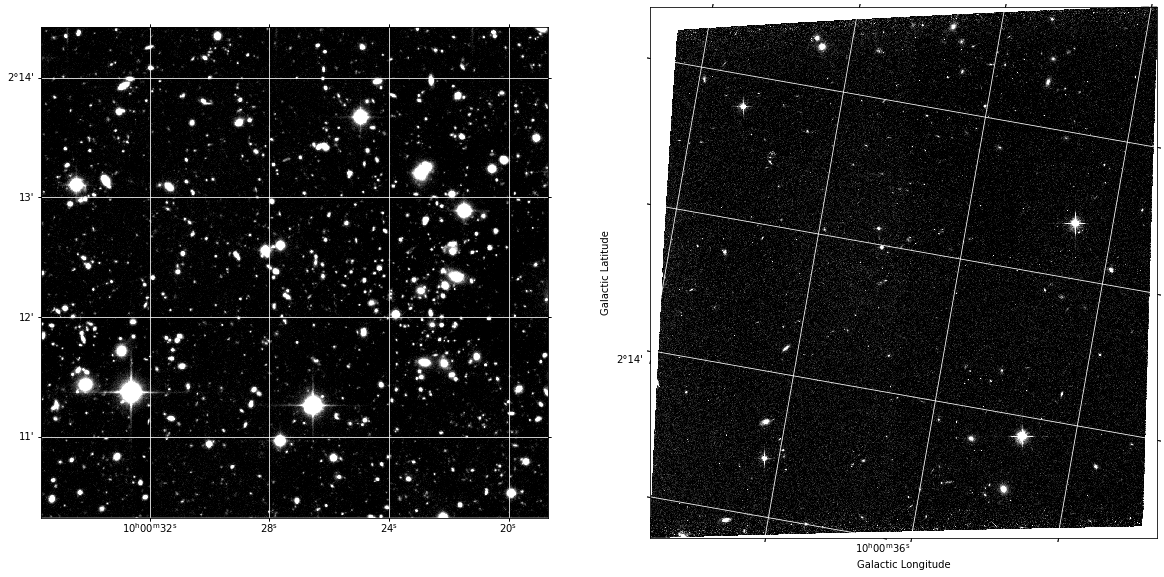

In [210]:
plot_images(cfht_image_data, cfht_w, hst_image_data, hst_w)

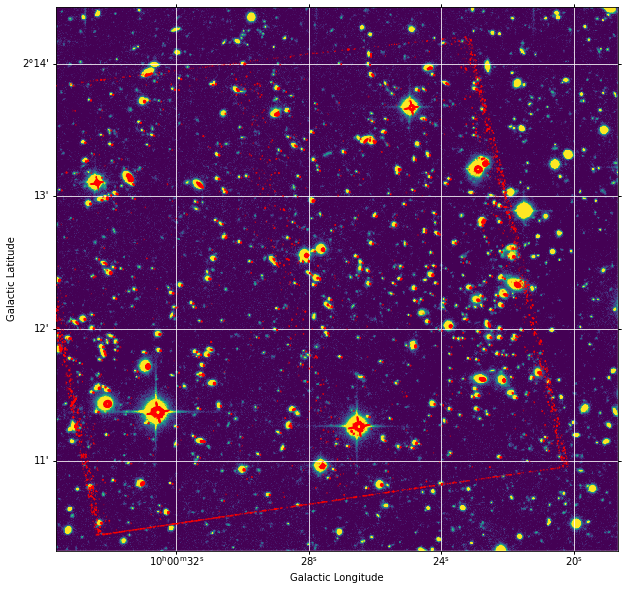

In [216]:
plot_dual_wcs_images(cfht_image_data, cfht_w, hst_image_data, hst_w)